In [1]:
import gzip
from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm
import numpy
import string
import random
from sklearn import linear_model
import scipy
import tensorflow as tf
import pandas as pd 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from collections import defaultdict
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def BER(predictions, y):
    TP = sum([(p and l) for (p,l) in zip(predictions, y)])
    FP = sum([(p and not l) for (p,l) in zip(predictions, y)])
    TN = sum([(not p and not l) for (p,l) in zip(predictions, y)])
    FN = sum([(not p and l) for (p,l) in zip(predictions, y)])
    TPR = TP / (TP + FN)
    TNR = TN / (TN + FP)
    BER = 1 - 1/2 * (TPR + TNR)
    return BER

In [6]:
data = pd.read_pickle("renttherunway_data_processed.pkl")
#data = pd.DataFrame(processed_data).to_dict('record')
data.dtypes

fit                       object
user_id                    int64
bust size                 object
item_id                    int64
weight                   float64
rating                   float64
rented for                object
review_text               object
body type                 object
review_summary            object
category                  object
height                   float64
size                       int64
age                      float64
review_date       datetime64[ns]
review_year                int64
review_month               int64
adjectives                 int64
review_length              int64
review_words               int64
review_ex                  int64
dtype: object

In [7]:
data.head(5)

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,...,height,size,age,review_date,review_year,review_month,adjectives,review_length,review_words,review_ex
0,fit,420272,34d,2260466,137.0,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,...,68.0,14,28.0,2016-04-20,2016,4,6,221,39,2
1,fit,273551,34b,153475,132.0,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,...,66.0,12,36.0,2013-06-18,2013,6,3,221,42,0
3,fit,909926,34c,126335,135.0,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,...,65.0,8,34.0,2014-02-12,2014,2,9,465,89,2
4,fit,151944,34b,616682,145.0,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,...,69.0,12,27.0,2016-09-26,2016,9,15,559,112,1
5,fit,734848,32b,364092,138.0,8.0,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,...,68.0,8,45.0,2016-04-30,2016,4,4,195,37,0


In [8]:
feature_list = []

In [9]:
#features to consider for the model 
bustsize = lambda x: int(x[0:2])
data["bust size"] = data["bust size"].apply(bustsize)

In [10]:
data.head(5)

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,...,height,size,age,review_date,review_year,review_month,adjectives,review_length,review_words,review_ex
0,fit,420272,34,2260466,137.0,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,...,68.0,14,28.0,2016-04-20,2016,4,6,221,39,2
1,fit,273551,34,153475,132.0,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,...,66.0,12,36.0,2013-06-18,2013,6,3,221,42,0
3,fit,909926,34,126335,135.0,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,...,65.0,8,34.0,2014-02-12,2014,2,9,465,89,2
4,fit,151944,34,616682,145.0,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,...,69.0,12,27.0,2016-09-26,2016,9,15,559,112,1
5,fit,734848,32,364092,138.0,8.0,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,...,68.0,8,45.0,2016-04-30,2016,4,4,195,37,0


In [11]:
btype_data = data["body type"].value_counts()
btypes = list(btype_data.keys())
feature_list += (btypes)
for btype in btypes:
  bfun = lambda x: 1 if (x==btype) else 0
  data[btype] = data["body type"].apply(bfun)

In [12]:
rtype_data = data["rented for"].value_counts()
rtypes = list(rtype_data.keys())
feature_list += rtypes
for rtype in rtypes:
  rfun = lambda x: 1 if (x==rtype) else 0
  data[rtype] = data["body type"].apply(rfun)

In [13]:
feature_list.remove('party: cocktail')

In [14]:
data.dtypes

fit                          object
user_id                       int64
bust size                     int64
item_id                       int64
weight                      float64
rating                      float64
rented for                   object
review_text                  object
body type                    object
review_summary               object
category                     object
height                      float64
size                          int64
age                         float64
review_date          datetime64[ns]
review_year                   int64
review_month                  int64
adjectives                    int64
review_length                 int64
review_words                  int64
review_ex                     int64
hourglass                     int64
athletic                      int64
pear                          int64
petite                        int64
straight & narrow             int64
full bust                     int64
apple                       

In [15]:
def feature(d):
    f = [1,
         d['rating'],
         d['review_length'],
         len(d['review_summary']),
         d['weight'],
         d['age'],
         d['height'],
         d['bust size']]
    for e in feature_list:
      f.append(d[e])
    return f

In [16]:
inputdata = pd.DataFrame(data).to_dict('record')
X = [feature(d) for d in inputdata]
y = [d['fit'] for d in inputdata]

In [17]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [18]:
X_train = X[0:int(0.8*len(data))]
X_test = X[int(0.8*len(data)):]

y_train = y[0:int(0.8*len(data))]
y_test = y[int(0.8*len(data)):]

In [22]:
model1 = linear_model.LogisticRegression(random_state=0, multi_class='multinomial', class_weight='balanced')
model1.fit(X_train, y_train)

ypred = model1.predict(X_test)
print('random_state: ',0)
test_accuracy = accuracy_score(y_test, ypred)
test_f1_score = f1_score(y_test, ypred, average='weighted')
test_precision_score = precision_score(y_test, ypred, average='weighted')
test_recall_score = recall_score(y_test, ypred, average='weighted')

print('Test Accuracy:', test_accuracy)
print('Test F1 Score:', test_f1_score)
print('Test Precision Score:', test_precision_score)
print('Test Recall Score:', test_recall_score)



random_state:  0
Test Accuracy: 0.5819354448010658
Test F1 Score: 0.6100788308435646
Test Precision Score: 0.6517726337242464
Test Recall Score: 0.5819354448010658


In [24]:

model2 = GradientBoostingClassifier(random_state=50)
model2.fit(X_train, y_train)

ypred = model2.predict(X_test)
print('random_state: ',50)
test_accuracy = accuracy_score(y_test, ypred)
test_f1_score = f1_score(y_test, ypred, average='weighted')
test_precision_score = precision_score(y_test, ypred, average='weighted')
test_recall_score = recall_score(y_test, ypred, average='weighted')

print('Test Accuracy:', test_accuracy)
print('Test F1 Score:', test_f1_score)
print('Test Precision Score:', test_precision_score)
print('Test Recall Score:', test_recall_score)


random_state:  50
Test Accuracy: 0.738902682734815
Test F1 Score: 0.6419162817173231
Test Precision Score: 0.6649164829658674
Test Recall Score: 0.738902682734815


In [37]:
model3 = AdaBoostClassifier(learning_rate=1)
model3.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME', learning_rate=1)

In [53]:
for i in [50,70,90,100]:
  model3 = AdaBoostClassifier(n_estimators=i)
  model3.fit(X_train, y_train)

  ypred = model3.predict(X_test)
  print('n_estimators: ',i)
  test_accuracy = accuracy_score(y_test, ypred)
  test_f1_score = f1_score(y_test, ypred, average='weighted')
  test_precision_score = precision_score(y_test, ypred, average='weighted')
  test_recall_score = recall_score(y_test, ypred, average='weighted')

  print('Test Accuracy:', test_accuracy)
  print('Test F1 Score:', test_f1_score)
  print('Test Precision Score:', test_precision_score)
  print('Test Recall Score:', test_recall_score)

  print('................')




n_estimators:  50
Test Accuracy: 0.7364803488160843
Test F1 Score: 0.6362905003314131
Test Precision Score: 0.6367964780631562
Test Recall Score: 0.7364803488160843
................
n_estimators:  70
Test Accuracy: 0.7366620238599891
Test F1 Score: 0.6366110498949408
Test Precision Score: 0.6409524204280885
Test Recall Score: 0.7366620238599891
................
n_estimators:  90
Test Accuracy: 0.7366014655120209
Test F1 Score: 0.6364521247768041
Test Precision Score: 0.6384948700154107
Test Recall Score: 0.7366014655120209
................
n_estimators:  100
Test Accuracy: 0.7365409071640525
Test F1 Score: 0.6364323920282786
Test Precision Score: 0.6398685881498074
Test Recall Score: 0.7365409071640525
................


In [58]:
import xgboost as xgb
for i in [0.01,0.2,0.4,0.8,1]:
  model4=xgb.XGBClassifier(random_state=50,learning_rate=i)
  model4.fit(X_train, y_train)

  ypred = model4.predict(X_test)
  print('learning_rates=',i)
  test_accuracy = accuracy_score(y_test, ypred)
  test_f1_score = f1_score(y_test, ypred, average='weighted')
  test_precision_score = precision_score(y_test, ypred, average='weighted')
  test_recall_score = recall_score(y_test, ypred, average='weighted')

  print('Test Accuracy:', test_accuracy)
  print('Test F1 Score:', test_f1_score)
  print('Test Precision Score:', test_precision_score)
  print('Test Recall Score:', test_recall_score)

  print('................')


learning_rates= 0.01
Test Accuracy: 0.7381759825591958
Test F1 Score: 0.6415017643840593
Test Precision Score: 0.6617514765421472
Test Recall Score: 0.7381759825591958
................
learning_rates= 0.2
Test Accuracy: 0.7385090534730212
Test F1 Score: 0.6412645143259534
Test Precision Score: 0.6641404886732213
Test Recall Score: 0.7385090534730212
................
learning_rates= 0.4
Test Accuracy: 0.7385393326470054
Test F1 Score: 0.6415826985233454
Test Precision Score: 0.6633361861675516
Test Recall Score: 0.7385393326470054
................
learning_rates= 0.8
Test Accuracy: 0.7381457033852117
Test F1 Score: 0.6428793626222234
Test Precision Score: 0.6601957136423321
Test Recall Score: 0.7381457033852117
................
learning_rates= 1
Test Accuracy: 0.7371464906437353
Test F1 Score: 0.6430775281741125
Test Precision Score: 0.6527332800848159
Test Recall Score: 0.7371464906437353
................


In [38]:
ypred = model3.predict(X_test)

test_accuracy = accuracy_score(y_test, ypred)
test_f1_score = f1_score(y_test, ypred, average='weighted')
test_precision_score = precision_score(y_test, ypred, average='weighted')
test_recall_score = recall_score(y_test, ypred, average='weighted')

print('Test Accuracy:', test_accuracy)
print('Test F1 Score:', test_f1_score)
print('Test Precision Score:', test_precision_score)
print('Test Recall Score:', test_recall_score)

Test Accuracy: 0.7371767698177194
Test F1 Score: 0.6256468534470543
Test Precision Score: 0.5434295899588869
Test Recall Score: 0.7371767698177194


In [ ]:
from sklearn.naive_bayes import BernoulliNB
model3 = BernoulliNB()
model3.fit(X, y)

BernoulliNB()

Test Accuracy: 0.7369950947738145
Test F1 Score: 0.6296185084688184
Test Precision Score: 0.5919198518197517
Test Recall Score: 0.7369950947738145
['fit' 'fit' 'fit' ... 'fit' 'fit' 'fit']


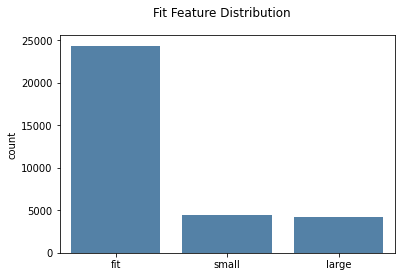

In [ ]:
ypred = model3.predict(X_test)

test_accuracy = accuracy_score(y_test, ypred)
test_f1_score = f1_score(y_test, ypred, average='weighted')
test_precision_score = precision_score(y_test, ypred, average='weighted')
test_recall_score = recall_score(y_test, ypred, average='weighted')

print('Test Accuracy:', test_accuracy)
print('Test F1 Score:', test_f1_score)
print('Test Precision Score:', test_precision_score)
print('Test Recall Score:', test_recall_score)
print(ypred)
fig = sns.countplot(y_test, color='steelblue').get_figure()
fig.suptitle("Fit Feature Distribution")
fig.savefig("fit_statistics.png")